In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as scio
import folium
from folium.plugins import HeatMap
import math
import bisect
import os
import json
import torch
from tqdm import tqdm
from tqdm.std import trange
import copy
import cv2
import pandas as pd

In [2]:
inputs = []
fname = 'oct31_oct26_v3'
for i in range(4):
    path = "./out/{}_r{}.pth".format(fname, i)
    temp = torch.load(path, map_location=torch.device("cpu"))
    inputs.extend(temp)
    
outputs_dict = torch.load("exp/oct23/inference/aicom_lane_test/oct23_debug01_m_0.pth", 
                          map_location=torch.device("cpu"))
test_imgs = outputs_dict["test_images"]
new_inputs =inputs[0:-1]
len(new_inputs)

54223

In [3]:
################# max height optimization
# new_inputs = copy.deepcopy(inputs[0:-1])

for i, it in enumerate(new_inputs):
    lines = it["final_lines"]
    max_h = 0
    for line in lines:
        max_h = max(720 - line[0][1], max_h)
    min_h = max_h * 0.75
    new_lines = list()
    for line in lines:
        if (720 - line[0][1]) < min_h:
            continue
        else:
            new_lines.append(line)
    
    new_inputs[i]["final_lines"] = new_lines

global_id = []
img = []
index = []
img_width = []
img_height = []
lane_prob = []
solid_prob = []
points = []
solid_type = []

for it in new_inputs:
    img_id, lines = it["img_id"], it["final_lines"]
    img_path = test_imgs[img_id].split('/')[-1]

    if len(lines) == 0:
        # print(img_id)
        global_id.append( img_id )
        img.append( img_path )
        index.append( 0 )
        img_width.append(1280)
        img_height.append(720)
        lane_prob.append( 1.0 )
        solid_prob.append( 1.0 )
        solid_type.append( 'solid' )
        points.append( [[1,1],[2,2]] )
        
    for lid, line in enumerate( lines ):
        line = [[int(pt[0]), int(pt[1])] for pt in line]
        
        global_id.append( img_id )
        img.append( img_path )
        index.append( lid )
        img_width.append(1280)
        img_height.append(720)
        lane_prob.append( 1.0 )
        solid_prob.append( 1.0 )
        solid_type.append( 'solid' )
        points.append( line )
        
# fname = 'oct31_oct26_v2'
cont_list = {'img':img, 'index':index, 'img_width':img_width, 'img_height':img_height,
         'prob':lane_prob,'solid_prob':solid_prob, 'solid_type':solid_type,'points':points}
df = pd.DataFrame(cont_list)
df.to_csv('./out/_outputs_{}.csv'.format(fname), index=False)

In [12]:
print([1151, 1352, 1621, 2270, 3653, 4058, 4557, 5970, 6902, 7102, 7165, 8088, 8911, 10156, 11793, 12048, 13913, 14057, 14084, 14492, 14980, 15257, 16086, 16355, 16514, 16819, 16840, 17269, 18844, 19033, 19686, 20154, 20644, 20732, 20757, 22052, 22113, 22147, 22180, 22282, 22605, 23238, 23874, 24080, 24151, 25551, 26748, 27309, 27563, 27658, 27736, 29836, 30282, 30365, 31583, 31597, 32628, 34345, 35411, 35757, 37622, 38844, 39004, 39253, 40769, 41721, 42560, 43457, 43540, 43965, 44847, 44906, 45661, 46430, 46716, 47028, 47119, 47752, 47906, 47921, 48737, 49492, 50381, 50611, 51032, 51401, 51465, 51736, 51761, 52198, 52645, 52977, 53526, 53657, 54095])

[1151, 1352, 1621, 2270, 3653, 4058, 4557, 5970, 6902, 7102, 7165, 8088, 8911, 10156, 11793, 12048, 13913, 14057, 14084, 14492, 14980, 15257, 16086, 16355, 16514, 16819, 16840, 17269, 18844, 19033, 19686, 20154, 20644, 20732, 20757, 22052, 22113, 22147, 22180, 22282, 22605, 23238, 23874, 24080, 24151, 25551, 26748, 27309, 27563, 27658, 27736, 29836, 30282, 30365, 31583, 31597, 32628, 34345, 35411, 35757, 37622, 38844, 39004, 39253, 40769, 41721, 42560, 43457, 43540, 43965, 44847, 44906, 45661, 46430, 46716, 47028, 47119, 47752, 47906, 47921, 48737, 49492, 50381, 50611, 51032, 51401, 51465, 51736, 51761, 52198, 52645, 52977, 53526, 53657, 54095]


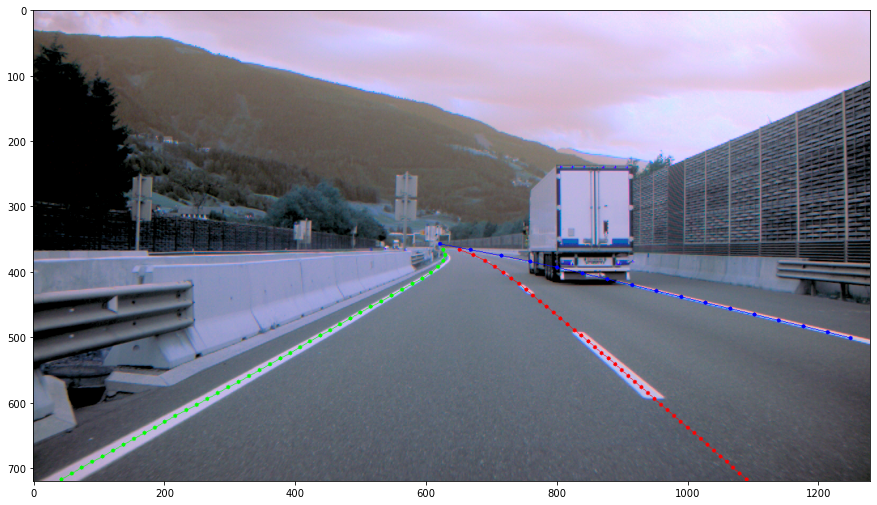

In [5]:
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]

idx = 26902
# temp = inputs[0:-1][idx]
temp = new_inputs[idx]
img_id = temp["img_id"]
lines = temp["final_lines"]
img_path = test_imgs[img_id].split('/')[-1]

img = cv2.imread('datasets/lane_detection/test/images/'+img_path)

for idx, pts in enumerate(lines):
    for i in range(len(pts)-1):
        x1 = int(pts[i][0])
        y1 = int(pts[i][1])
        x2 = int(pts[i+1][0])
        y2 = int(pts[i+1][1])
        cv2.circle(img, (x1,y1), 3, color[idx], -1)
        cv2.circle(img, (x2,y2), 3, color[idx], -1)
        cv2.line(img, (x1,y1), (x2,y2), color[idx], 1)       
plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.show() 

In [44]:
from maskrcnn_benchmark.utils.miscellaneous import mkdir
from tqdm import tqdm
color = [(255,0,0), (0,255,0),(0,0,255),\
         (255,255,0),(255,0,255),(0,255,255),(255,255,255),\
         (100,255,0),(100,0,255),(255,100,0),(0,100,255),(255,0,100),(0,255,100),(0,0,0)]

# 53235 13122 53237 24049 53235 47154 7994 7995 45315 161 2570 2739 
# 45315 47154 46000
# 2, 7, 8, 9, 10, 11, 13?, 16snow, 18 7906
folder_path = './out_img/test_17'
mkdir(folder_path)
test_list = [2, 7, 8, 9, 10, 11, 13, 16, 18, 7906, 53235, 13122,\
             53237, 24049, 53235, 47154, 7994, 7995, 45315, 161,\
             45315, 47154, 46000, 2570, 2739]
import random
randomlist = []
for i in range(0,100):
    n = random.randint(1,len(new_inputs))
    randomlist.append(n)
#test_list = randomlist
randomlist = [19660,22077,22279,26344,27837,28331,29117,30158,34150,35493,35774,36050,36235,37231,38519,39005,40139,41428,43319,44774,44824,44848,46428,47628,48361,52543,53296]
test_list = randomlist

for img_id in tqdm(test_list):
    temp = new_inputs[img_id]
    img_id = temp["img_id"]
    lines = temp["final_lines"]
    img_path = test_imgs[img_id].split('/')[-1]

    img = cv2.imread('datasets/lane_detection/test/images/'+img_path) 
        
    for lid, pts in enumerate(lines):
        if (720 - pts[0][1]) < min_h:
            continue
        for i in range(len(pts)-1):
            x1 = int(pts[i][0])
            y1 = int(pts[i][1])
            x2 = int(pts[i+1][0])
            y2 = int(pts[i+1][1])
            cv2.circle(img, (x1,y1), 3, color[lid], -1)
            cv2.circle(img, (x2,y2), 3, color[lid], -1)
            cv2.line(img, (x1,y1), (x2,y2), color[lid], 1)
        
    path = os.path.join(folder_path, 'pred_{}.png'.format(img_id))
    cv2.imwrite(path, img)

100%|██████████| 27/27 [00:02<00:00, 10.45it/s]


In [8]:
ones = []
for i, it in enumerate(new_inputs):
    ls = it["final_lines"]
    if len(ls) == 1:
        ones.append(i)

In [9]:
print(ones)

[1151, 1352, 1621, 2270, 3653, 4058, 4557, 5970, 6902, 7102, 7165, 8088, 8911, 10156, 11793, 12048, 13913, 14057, 14084, 14492, 14980, 15257, 16086, 16355, 16514, 16819, 16840, 17269, 18844, 19033, 19686, 20154, 20644, 20732, 20757, 22052, 22113, 22147, 22180, 22282, 22605, 23238, 23874, 24080, 24151, 25551, 26748, 27309, 27563, 27658, 27736, 29836, 30282, 30365, 31583, 31597, 32628, 34345, 35411, 35757, 37622, 38844, 39004, 39253, 40769, 41721, 42560, 43457, 43540, 43965, 44847, 44906, 45661, 46430, 46716, 47028, 47119, 47752, 47906, 47921, 48737, 49492, 50381, 50611, 51032, 51401, 51465, 51736, 51761, 52198, 52645, 52977, 53526, 53657, 54095]
